In our simple model, we look at cells that posess a state $s_i$. In a time evolution step, this state is subject to change according to
$$\frac{ds}{dt}=f(\vec{s})+\eta$$
where $f(\vec{s})$ is a function that (in general) depends on the states of all cells and $\eta$ is some gaussian random noise.

The Guassina random noise will be implemented through an Euoer-Maruyama algorithm. The simplest case which we will look at is that the cell can only speak to its direct neighbors, and does so through an averaging of signals, i.e., $f(\vec{s})=f((s_{i-1}+s_{i+1})/2)$.

I think this is the case if we have **diffusive communication**, i.e. every cell excretes a protein which diffuses to both sides. Thereby the cell cannot distinguish from which direction the protein comes, and only sees the average of its neighbors. (To be precise, this average should include the cells own state as well then).

Because the communication is agnostic to direction, the pattern that produces the most entropy and can be most reliably created is an on-off-pattern, which will be found in two variations since the system is also $Z_2$ symmetric. The regulatory function $f$ that leads to such an on-off-pattern is a *Sigmoid* or *tanh*, that will lead to lateral inhibition.

In [1]:
import sys
from importlib import reload

sys.path.insert(0, '../src')

import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as sns

# Import our self-written dynamics module
import dynamics
reload(dynamics)  # Reload to get latest changes
from dynamics import (
    get_neighbor_average,
    euler_step,
    simulate,
    apply_threshold,
    generate_initial_conditions,
    run_multiple_replicates
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")

JAX version: 0.4.35
JAX backend: cpu


In [2]:
# Lets define some parameters
N_CELLS = 7
DT = 0.01              # Time step
T = 20.0               # Simulation time
n_steps = int(T / DT)        # Number of time steps
NOISE_STRENGTH = 0.1   # Standard deviation of noise
N_REPLICATES = 20      # Number of independent simulations

# Random seed for reproducibility
SEED = 42
key = random.PRNGKey(SEED)

print(f"System size: {N_CELLS} cells")
print(f"Simulation parameters: T={T}, dt={DT}, steps={n}")
print(f"Noise strength: {NOISE_STRENGTH}")
print(f"Number of replicates: {N_REPLICATES}")

System size: 7 cells


NameError: name 'n' is not defined

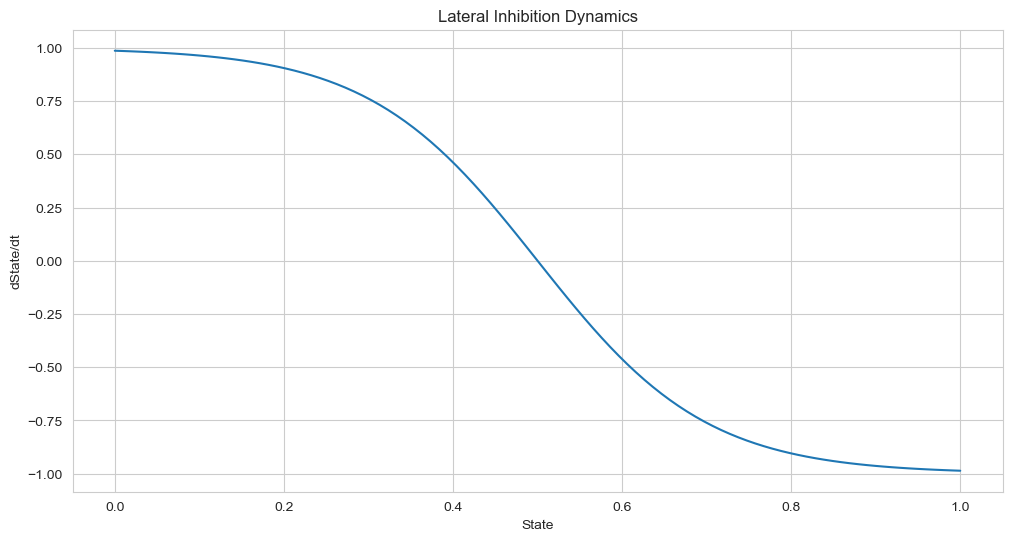

In [21]:
# Lets define a lateral inhibition function:
def lateral_inhibition(neighbor_avg, inhibition_strength=10.0):
    return jnp.tanh(-inhibition_strength * (neighbor_avg-0.5))

# And plot it for stati between 0 and 1
states = jnp.linspace(0, 1, 100)
dstate_dt = lateral_inhibition(states, inhibition_strength=5.0)
plt.plot(states, dstate_dt)
plt.xlabel('State')
plt.ylabel('dState/dt')
plt.title('Lateral Inhibition Dynamics')
plt.show()

Now we can run a deterministic simulation using the previously defined lateral inhibition function:

In [23]:
# Generate random initial conditions
key, ic_key, sim_key = random.split(key, 3)
initial_states = generate_initial_conditions(N_CELLS, ic_key)
initial_pattern = apply_threshold(initial_states)

print("Initial states:", initial_states)
print("Initial pattern:", initial_pattern)


# Run simulation with lateral inhibition, returning full trajectory
trajectory, times = simulate(
    f=lateral_inhibition,
    initial_states=initial_states,
    n_steps=n,
    dt=DT,
    noise_strength=NOISE_STRENGTH,
    key=sim_key,
    return_trajectory=True
)

print(f"\nTrajectory shape: {trajectory.shape} (time steps × cells)")
print(f"Final states: {apply_threshold(trajectory[-1])}")

Initial states: [0.5902162  0.5376897  0.49762416 0.46716994 0.54737824 0.4926577
 0.4789275 ]
Initial pattern: [1. 1. 0. 0. 1. 0. 0.]

Trajectory shape: (2001, 7) (time steps × cells)
Final states: [0. 1. 1. 0. 1. 0. 1.]


We can also visualise the evolution of the different cells:

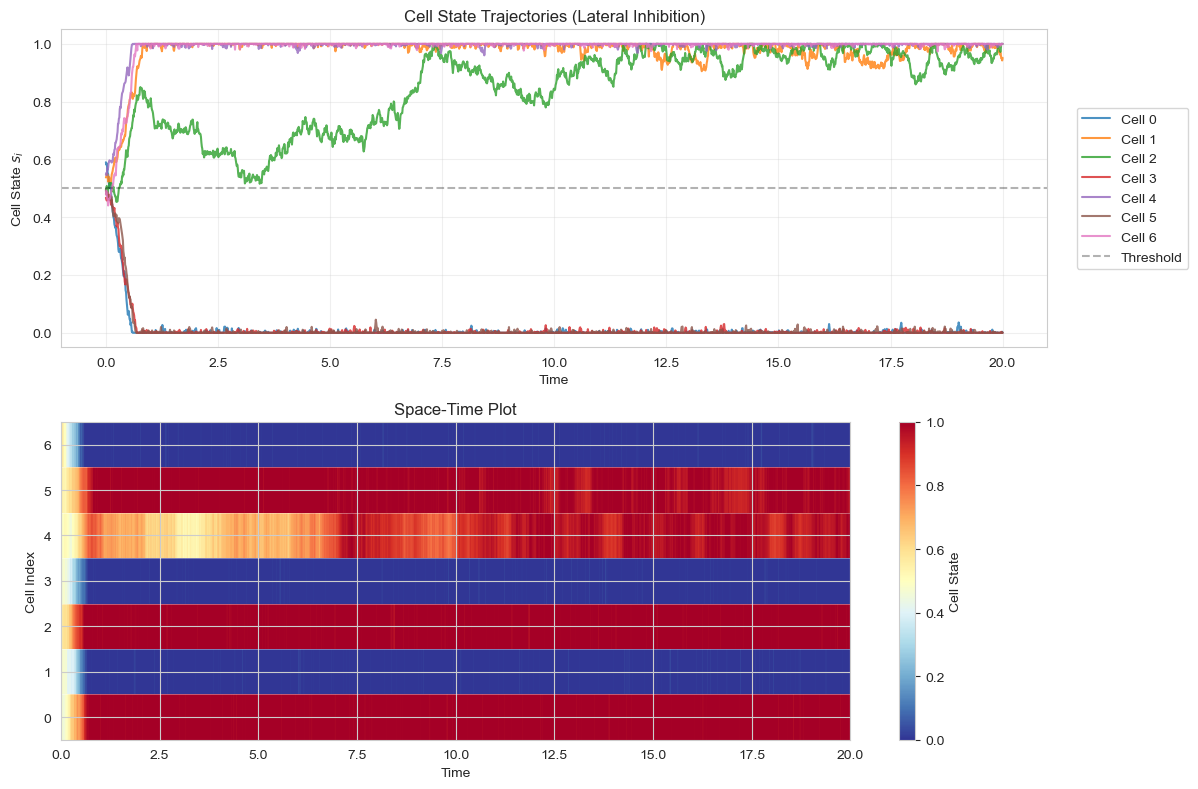


Final binary pattern: [0. 1. 1. 0. 1. 0. 1.]
Number of fate-1 cells: 4.0/7


In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top: Line plot of each cell over time
for i in range(N_CELLS):
    axes[0].plot(times, trajectory[:, i], label=f'Cell {i}', alpha=0.8)
axes[0].axhline(0.5, color='k', linestyle='--', alpha=0.3, label='Threshold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cell State $s_i$')
axes[0].set_title('Cell State Trajectories (Lateral Inhibition)')
axes[0].legend(loc='right', bbox_to_anchor=(1.15, 0.5))
axes[0].grid(True, alpha=0.3)

# Bottom: Heatmap (space-time plot)
im = axes[1].imshow(trajectory.T, aspect='auto', cmap='RdYlBu_r', 
                     extent=[0, T, -0.5, N_CELLS-0.5], vmin=0, vmax=1, interpolation='nearest')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cell Index')
axes[1].set_title('Space-Time Plot')
axes[1].set_yticks(range(N_CELLS))
# Add horizontal lines to separate cells
for i in range(N_CELLS + 1):
    axes[1].axhline(i - 0.5, color='white', linewidth=0.5, alpha=0.5)
plt.colorbar(im, ax=axes[1], label='Cell State')

plt.tight_layout()
plt.savefig('../figures/single_trajectory.png', dpi=150, bbox_inches='tight')
plt.show()

# Apply threshold and show final pattern
final_pattern = apply_threshold(trajectory[-1])
print(f"\nFinal binary pattern: {final_pattern}")
print(f"Number of fate-1 cells: {final_pattern.sum()}/{N_CELLS}")